## Reconhecimento de Gestos

Neste projeto foi desenvolvida uma solução que identifica gestos feitos com as mãos. Foram utilizados gestos do jogo pedra, papel e tesoura para treinar uma Rede Neural Convolucional obtendo acurácia de cerca de 95%

In [240]:
# Import library
import csv
import numpy as np
from os import getcwd
import os

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# set seaborn style on matplotlib
sns.set()  

### Mapeamento e pré-processamento 

In [241]:
# Find file path

rock_dir = os.path.join(getcwd(),'dataset','train','rock')
paper_dir = os.path.join(getcwd(),'dataset','train','paper')
scissors_dir = os.path.join(getcwd(),'dataset','train','scissors')


print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))
print('')
rock_files = os.listdir(rock_dir)
print(rock_files[:5])

paper_files = os.listdir(paper_dir)
print(paper_files[:5])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:5])

total training rock images: 840
total training paper images: 840
total training scissors images: 840

['rock01-000.png', 'rock01-001.png', 'rock01-002.png', 'rock01-003.png', 'rock01-004.png']
['paper01-000.png', 'paper01-001.png', 'paper01-002.png', 'paper01-003.png', 'paper01-004.png']
['scissors01-000.png', 'scissors01-001.png', 'scissors01-002.png', 'scissors01-003.png', 'scissors01-004.png']


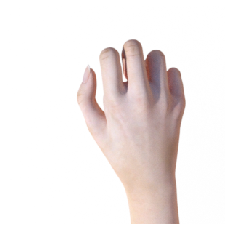

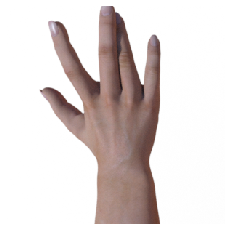

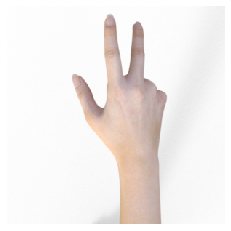

In [242]:
# Show some images 

pic_index = 4

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index:pic_index+1]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index:pic_index+1]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index:pic_index+1]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
    #print(img_path)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

In [254]:
# CNN hyperparams
BATCH_NUM = 64
EPOCHS_NUM = 30

# File locations
TRAINING_DIR = os.path.join(getcwd(),'dataset','train')
VALIDATION_DIR = os.path.join(getcwd(),'dataset','validation')
TEST_DIR = os.path.join(getcwd(),'dataset','test')

In [262]:
# Use ImageDataGenerator to resize, scale, rotate,..., images
# The command 'flow_from_direct' read images from folders and adjust image's shape. It's possible create labels too

# Training Data
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=60,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = training_datagen.flow_from_directory(
      TRAINING_DIR,
      target_size=(150,150),
      class_mode='categorical',
      batch_size=BATCH_NUM
)

# Validation Data
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
      VALIDATION_DIR,
      target_size=(150,150),
      class_mode='categorical',
      batch_size=BATCH_NUM
)

# Test Data
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
      TEST_DIR,
      target_size=(150,150),
      class_mode='categorical',
      batch_size=BATCH_NUM,
      shuffle=False
)

# confirm the iterator works
batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Batch shape=(64, 150, 150, 3), min=0.029, max=1.000


### Criação do modelo

In [266]:
# Resets all state generated by Keras.
tf.keras.backend.clear_session()
# Define the model
# Use no more than 2 Conv2D and 2 MaxPooling2D
model = Sequential()

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.1))

model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.1))

model.add(Conv2D(20 , (3,3), activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3 , activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 50)        28850     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 50)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 38, 50)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 38, 25)        11275     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 25)       

### Etapa de treinamento 

In [267]:
# Define a Callback class that stops training once accuracy reaches 99.5%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') >= 0.954):
            print("\nReached 95.4% accuracy so cancelling training!")
            self.model.stop_training = True

            
            
callback = myCallback()

# Compile Model. 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator, 
                    epochs=EPOCHS_NUM, 
                    steps_per_epoch=round(train_generator.samples / BATCH_NUM), 
                    validation_data = validation_generator, 
                    verbose = 1, 
                    validation_steps=round(validation_generator.samples / BATCH_NUM),
                    callbacks=[callback])

Epoch 1/30
39/39 [==============================] - 75s 2s/step - loss: 1.0780 - accuracy: 0.3901 - val_loss: 0.8625 - val_accuracy: 0.7339
Epoch 2/30
39/39 [==============================] - 75s 2s/step - loss: 0.9909 - accuracy: 0.5000 - val_loss: 0.7276 - val_accuracy: 0.7339
Epoch 3/30
39/39 [==============================] - 73s 2s/step - loss: 0.8317 - accuracy: 0.5863 - val_loss: 0.4690 - val_accuracy: 0.8710
Epoch 4/30
39/39 [==============================] - 70s 2s/step - loss: 0.6593 - accuracy: 0.7060 - val_loss: 0.3926 - val_accuracy: 0.8925
Epoch 5/30
39/39 [==============================] - 70s 2s/step - loss: 0.5884 - accuracy: 0.7500 - val_loss: 0.2088 - val_accuracy: 0.9247
Epoch 6/30
39/39 [==============================] - 71s 2s/step - loss: 0.4728 - accuracy: 0.8131 - val_loss: 0.1607 - val_accuracy: 0.9435
Epoch 7/30
39/39 [==============================] - 71s 2s/step - loss: 0.3998 - accuracy: 0.8457 - val_loss: 0.2254 - val_accuracy: 0.9543
Epoch 8/30
39/39 [==

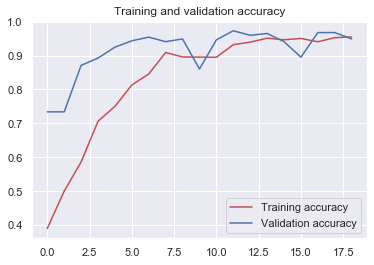

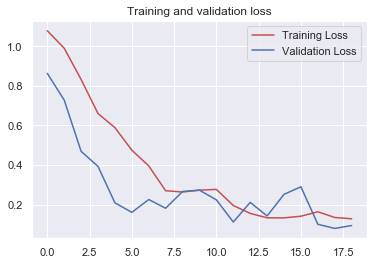

In [268]:
# Plot the chart for accuracy and loss on both training and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Aplicação do modelo nos dados de teste

In [269]:
print("Number of images for testing: ", test_generator.samples)
print("Classes index: ",test_generator.class_indices)
predict = model.predict_generator(test_generator) 

Number of images for testing:  33
Classes index:  {'paper': 0, 'rock': 1, 'scissors': 2}


In [270]:
# check predictions
print(predict)

[[9.9999869e-01 4.6247856e-11 1.3308648e-06]
 [9.9996483e-01 1.7763030e-08 3.5110334e-05]
 [9.9828017e-01 1.3689499e-03 3.5089630e-04]
 [9.9997163e-01 4.6749086e-08 2.8396769e-05]
 [9.0044552e-01 1.0051681e-06 9.9553555e-02]
 [9.6502066e-01 6.0893126e-06 3.4973279e-02]
 [2.5945860e-01 4.2633722e-03 7.3627806e-01]
 [9.9999642e-01 3.4675284e-07 3.2124999e-06]
 [9.9991751e-01 1.7584275e-08 8.2523678e-05]
 [9.9999702e-01 8.3578399e-08 2.8017910e-06]
 [2.8863654e-01 3.3767324e-02 6.7759609e-01]
 [3.8626733e-09 1.0000000e+00 1.5847354e-10]
 [3.8080086e-06 9.9999321e-01 2.9297344e-06]
 [1.6390203e-06 9.9996400e-01 3.4278171e-05]
 [1.4603170e-05 9.9993098e-01 5.4364984e-05]
 [3.6491736e-05 9.9994671e-01 1.6819313e-05]
 [1.2962139e-06 9.9996734e-01 3.1334446e-05]
 [5.6928943e-04 9.7768980e-01 2.1740796e-02]
 [1.2694527e-05 9.9989140e-01 9.5801166e-05]
 [3.3400580e-04 9.9758291e-01 2.0830201e-03]
 [2.2388392e-08 1.0000000e+00 4.4637641e-08]
 [2.7513519e-05 9.9936169e-01 6.1073725e-04]
 [6.241311

In [271]:
# convert array of probabilities to unique value
y_pred = []
for i in predict:
    y_pred.append(np.argmax(i))
    
y_pred = np.array(y_pred) 
print(y_pred)

[0 0 0 0 0 0 2 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]


In [272]:
# check real labels
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

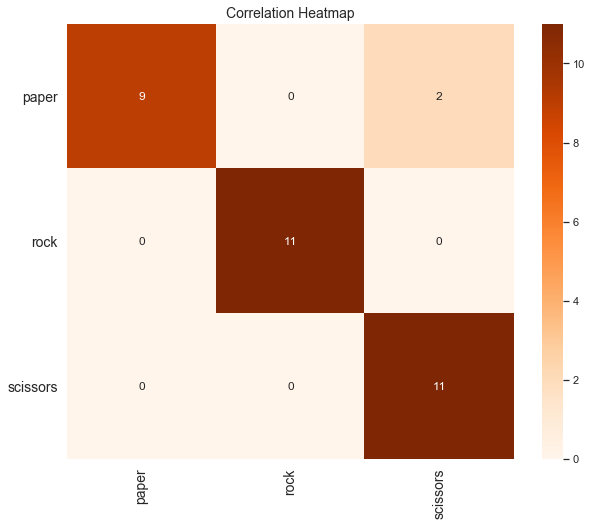

In [273]:
# performance analisys using confusion matrix
matrix = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
s = sns.heatmap(data=matrix,
                annot=True,
                cmap='Oranges')
s.set_yticklabels({'paper': 0, 'rock': 1, 'scissors': 2}, rotation=0, fontsize=14)
s.set_xticklabels({'paper': 0, 'rock': 1, 'scissors': 2}, rotation=90, fontsize=14)
plt.title("Correlation Heatmap",fontsize=14)
plt.show()

In [274]:
# salva modelo
model.save('modeloV3.h5')

### Carrega Imagem e realiza predição


In [283]:
# dimensions of our images
img_width, img_height = 150, 150

# load the model we saved
model = tf.keras.models.load_model('modeloV3.h5')


# predicting images
img = image.load_img('testes/scissors-hires2.png', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.
images = np.vstack([x])
classes = model.predict_classes(images, batch_size=1)
print(classes)

[2]


In [284]:
model.predict(images)

array([[4.6062085e-04, 2.5797835e-05, 9.9951363e-01]], dtype=float32)